# Compare the Ocean O2 fluxes

We look at three ocean o2 fluxes from the:
- ECCO model,
- Jena CarboScope inversion,
- NEMO model.

We compare the fields, selecting a time when there is large ocean contribution so as to see what the fields and the footprints look like at this time

In [6]:
import os 
import sys
import numpy as np
import pandas as pd
import datetime as dt
import cartopy.crs as ccrs
from matplotlib import ticker
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
# from matplotlib.ticker import ScalarFormatter
# from matplotlib.ticker import FormatStrFormatter

from acrg.name import name

import apo_funcs

## Inputs

We give the inputs for the data that we are comparing

The time, day, month, and year should refer to a time at which there is a large O2 contribution from the ocean 

In [2]:
# manual inputs
year = 2014
month = 8
day = 28
time = '00:00'

site = 'WAO'
resolution = 'day'
climatology = False

# automated inputs from above
date_check = f'{year}-{str(month).zfill(2)}-{str(day).zfill(2)}'

fp_date_check = date_check if time is None else f'{date_check}T{time}'

## Get the fluxes and footprints

### Import the data

In [3]:
em_name = {sim: f'o2-{sim}-ocean-{resolution}' for sim in ['ecco', 'jena', 'nemo']}

flux_data = {sim: name.flux(domain='EUROPE',
                            species=em_sim,
                            start=f'{year}-01-01',
                            end=f'{year+1}-01-01')
             for sim, em_sim in em_name.items()}
footprint = name.footprints('WAO', met_model='UKV',
                            start=f'{year}-01-01',
                            end=f'{year+1}-01-01',
                            domain='EUROPE')


Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/o2-ecco-ocean-day_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-ecco-ocean-day_EUROPE_2014.nc
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-ecco-ocean-day_EUROPE_2015.nc
Slicing time to range 2014-01-01 00:00:00 - 2014-12-31 23:59:59

Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/o2-jena-ocean-day_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-jena-ocean-day_EUROPE_2014.nc
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-jena-ocean-day_EUROPE_2015.nc
Slicing time to range 2014-01-01 00:00:00 - 2014-12-31 23:59:59

Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/o2-nemo-ocean-day_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-nemo-ocean-day_EUROPE_2014.nc
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-nemo-ocean-day_EUROPE_2015.nc
Slicing time to range 2014

### Crop the data and work out any limits for plotting

In [4]:
date_check = pd.to_datetime(date_check)
flux_date_check = dt.datetime(date_check.year, date_check.month, 1) if resolution=='mth' else date_check

flux_check = {sim: fl_sim.sel(time=flux_date_check).flux.fillna(0) for sim, fl_sim in flux_data.items()}
flux_check['footprint'] = footprint.fp.sel(time=fp_date_check)

flux_crop = {sim: flux_sim.loc[dict(lat=slice(45, 63), lon=slice(-15, 8))]*1e6 if sim!='footprint' else \
                  flux_sim.loc[dict(lat=slice(45, 63), lon=slice(-15, 8))]
             for sim, flux_sim in flux_check.items()}
vmin = np.array([np.nanpercentile(fl, 0.1) for fl in flux_crop.values()]).min()
vmin = np.array([np.nanmin(fl) for fl in flux_crop.values()]).min()
vmax = np.nanpercentile(flux_crop['nemo'], 99.99)

### Show the fields

Show the three fields and the footprint

0: black
1: black
2: black
3: white


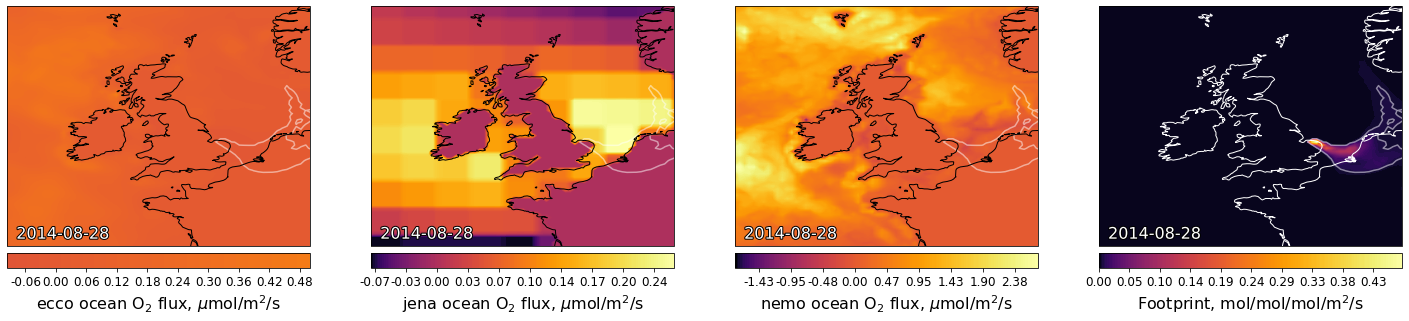

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(25, 13), subplot_kw={'projection': ccrs.PlateCarree()})
for ff, (sim, flux_sim) in enumerate(flux_crop.items()):
    vmin_sim = vmin if sim in ['ecco', 'nemo'] else None
    vmax_sim = vmax if sim in ['ecco', 'nemo'] else None
    cmap = 'inferno' #plt.cm.get_cmap('inferno').reversed() if ff==3 else 'inferno'
    coast_color = 'white' if ff==3 else 'black'
    print(f'{ff}: {coast_color}')

    scale = colors.PowerNorm(gamma=0.5) if sim == footprint else colors.NoNorm
    im_flux = axes[ff].contourf(flux_sim.lon, flux_sim.lat, flux_sim,
                                cmap = cmap, levels=200,
                                vmin = vmin_sim, vmax = vmax_sim,
                                transform = ccrs.PlateCarree(),
                                norm = scale)
    cbar_label = sim+r' ocean O$_2$ flux, $\mu$mol/m$^2$/s' if sim in ['ecco', 'jena', 'nemo'] else r'Footprint, mol/mol/mol/m$^2$/s'
    # cbar_label = '' if sim in ['ecco', 'jena', 'nemo'] else r'Footprint, mol/mol/mol/m$^2$/s'
    cbar = plt.colorbar(im_flux, ax=axes[ff], orientation='horizontal', pad=0.01)
    cbar.set_label(label=cbar_label, fontsize=16)
    cbar.ax.tick_params(labelsize=12)
    # if sim in ['ecco', 'jena', 'nemo']:
    cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))
    date_text = flux_date_check if sim in ['ecco', 'jena', 'nemo'] else date_check
    text = axes[ff].text(0.03, 0.03, date_text.date(), transform=axes[ff].transAxes, fontsize=16, color='white',
                         path_effects=[pe.withStroke(linewidth=2, foreground="black")])
    coast = axes[ff].coastlines(resolution='50m', color=coast_color, linewidth=1, zorder=20)

# xlabel_flux = fig.text(0.41, 0.19, 'ocean O$_2$ flux, $\mu$mol/m$^2$/s', va='center', ha='center', rotation='horizontal', fontsize=16)

im_fp = [ax.contour(flux_check['footprint'].loc[dict(lat=slice(45, 63), lon=slice(-15, 8))].lon,
                    flux_check['footprint'].loc[dict(lat=slice(45, 63), lon=slice(-15, 8))].lat,
                    flux_check['footprint'].loc[dict(lat=slice(45, 63), lon=slice(-15, 8))],
                    transform = ccrs.PlateCarree(),
                    zorder=10, colors='white', levels=[0.005], alpha=0.5) for ax in axes]

filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'FluxFields', f'OceanFluxComparison_{resolution}_{date_check.strftime("%Y%m%d")}.png')
# print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight')